# Logistic Regression
Logistic regression is a **supervised classification model** used when the outcome we want to predict is categorical, and most commonly binary (e.g. disease vs. no disease).

## Formulation
Logistic regression predicts the probability that the target is in the **positive** class:
$$ p(x) = \Pr(y = 1 | x)$$
This is done by:
1. Compute a linear score (a weighted sum of features): $$z = \beta_0 + \beta^T x.$$
2. Passing that score through the logistic function to map it into $[0, 1]$: $$p(x) = \sigma(x) = \frac{1}{1 + e^{-z}}.$$

The model is called logistics regression because it is linear for **log-odds**. As we can verify, the **odds** is given by $\frac{p}{1-p}$, and the log-odds therefore is $$\log\frac{p}{1-p} = \beta_0 + \beta^T x.$$

## Training
For a dataset $\{(x_i, y_i)\}^n_{i=1}, y_i \in \{0, 1\}$ for all $i$, the loss function is given by 
$$\mathcal{L}(\beta) = -\sum^n_{i=1}[y_i\log p_i + (1 - y_i)\log(1 - p_i)].$$

In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    precision_score,
    recall_score,
)
import matplotlib.pyplot as plt
import os
import kagglehub

from models.linear_models import LogisticRegression as LRImpl

/Users/q/ml-practice/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = kagglehub.dataset_download("uciml/breast-cancer-wisconsin-data")
cache_dir = os.path.expanduser("~/.cache/kagglehub/datasets/uciml/breast-cancer-wisconsin-data")
csv_files = [f for f in os.listdir(path) if f.endswith(".csv")]
csv_path = os.path.join(path, csv_files[0])
df = pd.read_csv(csv_path)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
print(f"M len: {len(df[df["diagnosis"] == "M"])}")
print(f"not M len: {len(df[df["diagnosis"] != "M"])}")

M len: 212
not M len: 357


In [4]:
# Prepare the data
# The Breast Cancer Wisconsin dataset typically has 'diagnosis' as the target (M=Malignant, B=Benign)
# and 'id' column that should be dropped
target_col = "diagnosis"

# Separate features and target
X = df.drop([target_col, "id", "Unnamed: 32"], axis=1)
y = df[target_col]

# Encode the 'diagnosis' column to 0 and 1.
y = y.map({"M": 1, "B": 0, "Malignant": 1, "Benign": 0})

# Handle any missing values
# X = X.select_dtypes(include=[np.number])  # Keep only numeric columns
# X = X.fillna(X.mean())  # Fill missing values with mean

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"\nFeature columns: {X.columns.tolist()}")

Features shape: (569, 30)
Target shape: (569,)
Target distribution:
diagnosis
0    357
1    212
Name: count, dtype: int64

Feature columns: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 455
Test set size: 114


In [6]:
# Scale the features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# X_train_scaled = X_train
# X_test_scaled = X_test

print("Features scaled successfully")

# Train the logistic regression model
model = LogisticRegression(random_state=42, max_iter=5000)
model.fit(X_train_scaled, y_train)

print("Model trained successfully!")
print(f"Model coefficients shape: {model.coef_.shape}")
print(f"model coef: {model.coef_}")
print(f"Model intercept: {model.intercept_[0]:.4f}")

Features scaled successfully
Model trained successfully!
Model coefficients shape: (1, 30)
model coef: [[ 0.36115007  0.4822194   0.35315987  0.43995028  0.35062156 -0.43954615
   0.78229835  0.95281283 -0.16399087 -0.08086512  1.23332517 -0.40761126
   0.74829471  0.90902906  0.24799098 -0.9069248  -0.09234069  0.48208908
  -0.33065773 -0.59387632  0.89696783  1.43409317  0.72311148  0.90047661
   0.42020675 -0.17348751  0.9114058   0.70399881  1.06126366  0.05486988]]
Model intercept: -0.2430


In [7]:
# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy * 100:.2f}%)")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy * 100:.2f}%)")

Training Accuracy: 0.9868 (98.68%)
Test Accuracy: 0.9649 (96.49%)


In [8]:
# Detailed classification report
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=["Benign", "Malignant"]))

Classification Report (Test Set):
              precision    recall  f1-score   support

      Benign       0.96      0.99      0.97        72
   Malignant       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [9]:
# Confusion matrix
print("Confusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)
print(f"\nTrue Negatives (Benign correctly predicted): {cm[0][0]}")
print(f"False Positives: {cm[0][1]}")
print(f"False Negatives: {cm[1][0]}")
print(f"True Positives (Malignant correctly predicted): {cm[1][1]}")

Confusion Matrix (Test Set):
[[71  1]
 [ 3 39]]

True Negatives (Benign correctly predicted): 71
False Positives: 1
False Negatives: 3
True Positives (Malignant correctly predicted): 39


# Model Evaluation
To evaluate the performance of a model, we often use **confusion matrix** and notions derived from it.

|                                       | Positive sample $(y=1)$ | Negative sample $(y=0)$ |
| ------------------------------------- | ----------------------: | ----------------------: |
| Predicted to be true $(\hat y=1)$     | True Positive (TP)      | False Positive (FP)     |
| Predicted to be false $(\hat y=0)$    | False Negative (FN)     | True Negative (TN)      |

## Metrics
### Accuracy
Accuracy is the portion of true samples of the model inference. It is practical when the classes are balanced.
$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}.$$
However, when the positive and negative samples are im-balance, the accuracy is meaningless. For instance, when we are training a model on a dataset containing 1% malignant and 99% benign patients. 99% accuracy on diagnostic says nothing because what really important is the evaluation on whether the model can diagnose the 1% of the malignant patients.

### Precision
Precision is the number of true amount the samples that are labelled as positive.
$$\text{Precision} = \frac{TP}{TP + FP}.$$

### Recall
$$\text{Recall} = \frac{TP}{TP + FN}.$$

## Related curves
### ROC curve
ROC (receiver operating characteristic) curve is the curve plotted when the threshold of classification is varied from 1 to zero, with the:
- y-axis to be the **true positive rate (TPR)** = Recall: $\frac{TP}{TP + FN}$.
- x-axis to be the **false positive rate (FPT)**: $\frac{FP}{FP + TN}$.

AUC (Area Under the ROC Curve) is, the area under the ROC curve, which is a value lies within 0-1. It is important to note for the interpretation: randomly draw a positive (P) and negative (N) sample from the population, ROC-AUC is equivalent to the probability that the score of P is higher than N. It implies that ROC-AUC only cares about the ranking quality, and it is not sensitive to the normalization of the logit (the rank is unchanged if the logit is normalized by sigmoid function).

A "good" ROC-AUC curve is skewed to the top-left corner of the graph.

#### Tradeoffs
When there is a large number of false positives, our ROC-AUC curve maybe optimistic.

### PR curve



In [10]:
# Get prediction probabilities for ROC and PR curves
y_train_proba = model.predict_proba(X_train_scaled)[:, 1]  # Probability of positive class
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

print("Prediction probabilities obtained")
print(f"Test probabilities range: [{y_test_proba.min():.4f}, {y_test_proba.max():.4f}]")

Prediction probabilities obtained
Test probabilities range: [0.0000, 1.0000]


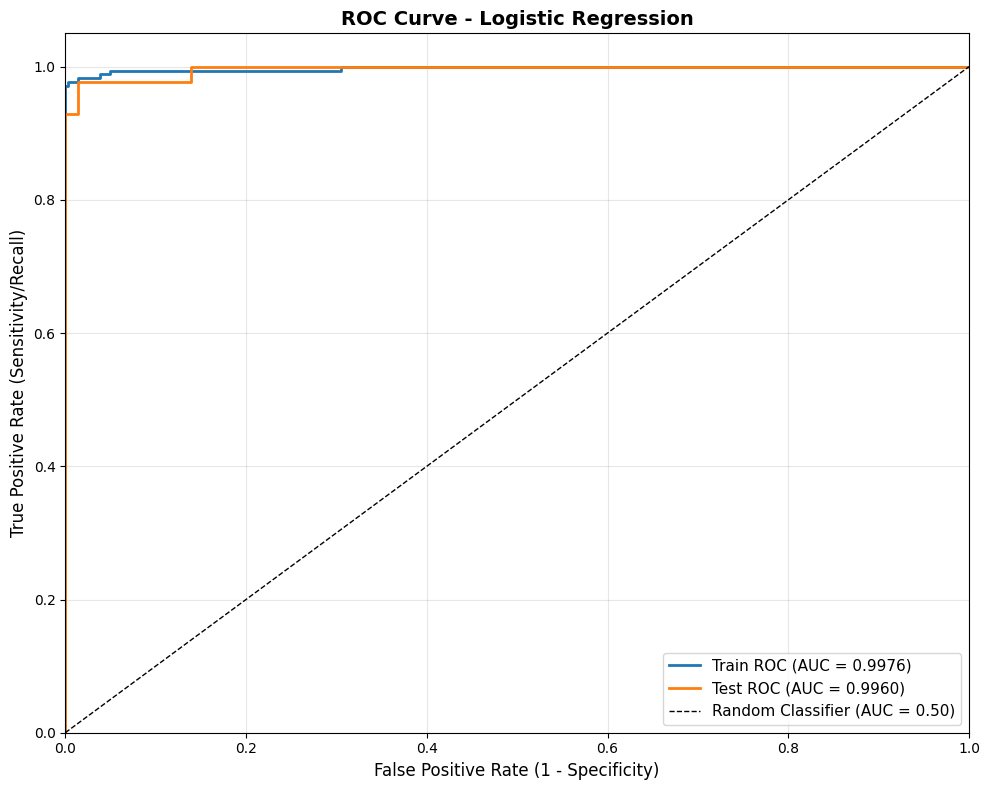

Train AUC: 0.9976
Test AUC: 0.9960


In [11]:
# Calculate ROC curve metrics
fpr_train, tpr_train, thresholds_roc_train = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, thresholds_roc_test = roc_curve(y_test, y_test_proba)

# Calculate AUC scores
auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.4f})", linewidth=2)
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {auc_test:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier (AUC = 0.50)", linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (1 - Specificity)", fontsize=12)
plt.ylabel("True Positive Rate (Sensitivity/Recall)", fontsize=12)
plt.title("ROC Curve - Logistic Regression", fontsize=14, fontweight="bold")
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Train AUC: {auc_train:.4f}")
print(f"Test AUC: {auc_test:.4f}")

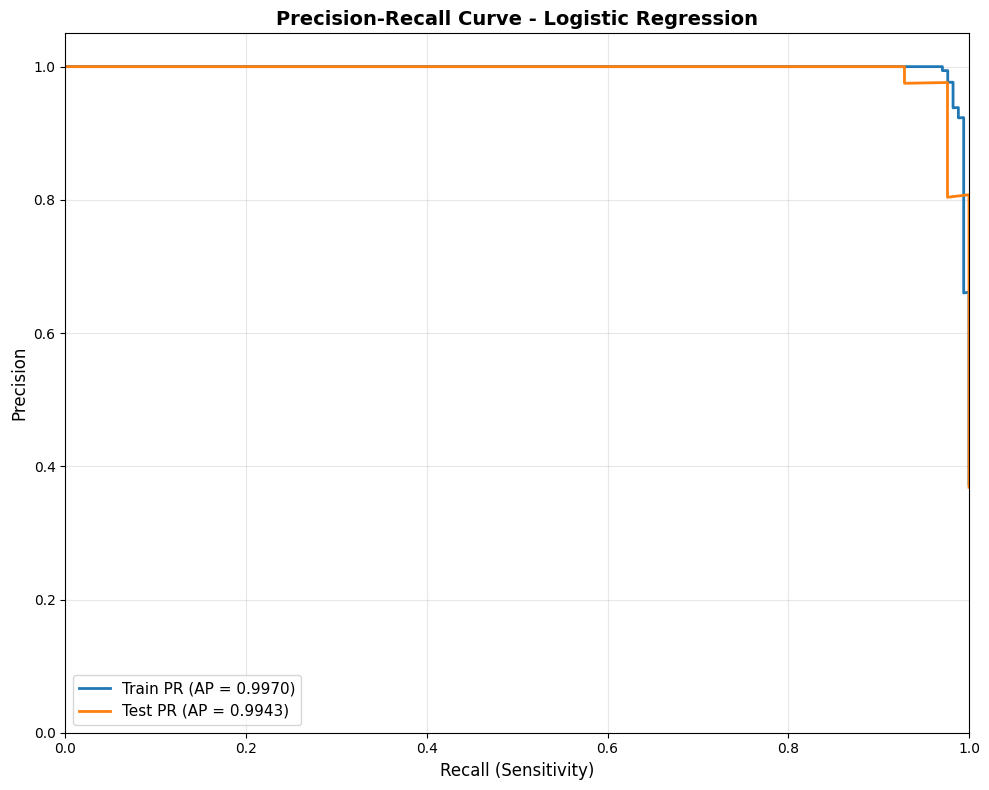

Train Average Precision: 0.9970
Test Average Precision: 0.9943


In [12]:
# Calculate Precision-Recall curve metrics
precision_train, recall_train, thresholds_pr_train = precision_recall_curve(y_train, y_train_proba)
precision_test, recall_test, thresholds_pr_test = precision_recall_curve(y_test, y_test_proba)

# Calculate Average Precision (AP) scores
ap_train = average_precision_score(y_train, y_train_proba)
ap_test = average_precision_score(y_test, y_test_proba)

# Plot PR curve
plt.figure(figsize=(10, 8))
plt.plot(recall_train, precision_train, label=f"Train PR (AP = {ap_train:.4f})", linewidth=2)
plt.plot(recall_test, precision_test, label=f"Test PR (AP = {ap_test:.4f})", linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall (Sensitivity)", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve - Logistic Regression", fontsize=14, fontweight="bold")
plt.legend(loc="lower left", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Train Average Precision: {ap_train:.4f}")
print(f"Test Average Precision: {ap_test:.4f}")

In [13]:
# Calculate Precision and Recall at different thresholds
thresholds = np.arange(0.1, 1.0, 0.05)  # Thresholds from 0.1 to 0.95 with step 0.05
precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds:
    y_pred_threshold = (y_test_proba >= threshold).astype(int)
    prec = precision_score(y_test, y_pred_threshold, zero_division=0)
    rec = recall_score(y_test, y_pred_threshold, zero_division=0)
    f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

    precision_scores.append(prec)
    recall_scores.append(rec)
    f1_scores.append(f1)

# Create a DataFrame for the threshold table
threshold_table = pd.DataFrame(
    {
        "Threshold": thresholds,
        "Precision": precision_scores,
        "Recall": recall_scores,
        "F1-Score": f1_scores,
    }
)

# Display the table
print("Precision and Recall at Different Thresholds (Test Set):")
print("=" * 70)
print(threshold_table.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
print("=" * 70)

Precision and Recall at Different Thresholds (Test Set):
 Threshold  Precision  Recall  F1-Score
    0.1000     0.8913  0.9762    0.9318
    0.1500     0.9111  0.9762    0.9425
    0.2000     0.9111  0.9762    0.9425
    0.2500     0.9762  0.9762    0.9762
    0.3000     0.9762  0.9762    0.9762
    0.3500     0.9756  0.9524    0.9639
    0.4000     0.9756  0.9524    0.9639
    0.4500     0.9756  0.9524    0.9639
    0.5000     0.9750  0.9286    0.9512
    0.5500     1.0000  0.9286    0.9630
    0.6000     1.0000  0.9048    0.9500
    0.6500     1.0000  0.9048    0.9500
    0.7000     1.0000  0.9048    0.9500
    0.7500     1.0000  0.9048    0.9500
    0.8000     1.0000  0.8571    0.9231
    0.8500     1.0000  0.8571    0.9231
    0.9000     1.0000  0.7857    0.8800
    0.9500     1.0000  0.7381    0.8493


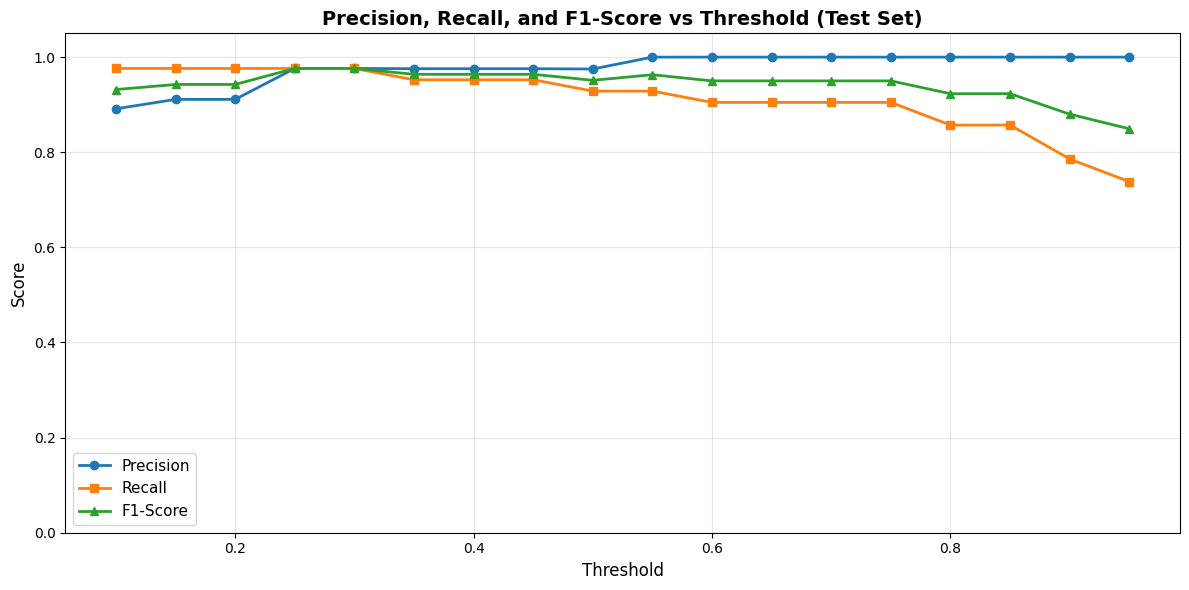

In [14]:
# Visualize Precision and Recall vs Threshold
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precision_scores, "o-", label="Precision", linewidth=2, markersize=6)
plt.plot(thresholds, recall_scores, "s-", label="Recall", linewidth=2, markersize=6)
plt.plot(thresholds, f1_scores, "^-", label="F1-Score", linewidth=2, markersize=6)
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Precision, Recall, and F1-Score vs Threshold (Test Set)", fontsize=14, fontweight="bold")
plt.legend(loc="best", fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

In [15]:
# Experiment: Data Leak

scalar = StandardScaler()
scalar.fit(X)

X_train_leaked_scaled = scalar.transform(X_train)
X_test_leaked_scaled = scaler.transform(X_test)

model = LogisticRegression(random_state=42, max_iter=5000)
model.fit(X_train_leaked_scaled, y_train)

# Make predictions
y_train_pred = model.predict(X_train_leaked_scaled)
y_test_pred = model.predict(X_test_leaked_scaled)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy * 100:.2f}%)")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy * 100:.2f}%)")

Training Accuracy: 0.9868 (98.68%)
Test Accuracy: 0.9737 (97.37%)


# Interpretation 
The result shows:
- the training accuracy is unchanged. This is because the model we are using (logistic regression) can adapt its parameter according to affine feature changes.
- However, there is the test accuracy is increased (from 96.49% to 97.37% with data leak). It matches with our intuition as the standardization is performed on the entire dataset during the data leak experiment, result in a more thorough standardization. However, the result test result is over-optimistic because we never know the true population mean and the true population variance in the real world practice.

# Below is a self-implemented logistic regression

Epoch   10 | train_loss=0.916494
Epoch   20 | train_loss=0.437188
Epoch   30 | train_loss=0.404814
Epoch   40 | train_loss=0.398167
Epoch   50 | train_loss=0.394760
Epoch   60 | train_loss=0.392453
Epoch   70 | train_loss=0.390809
Epoch   80 | train_loss=0.389627
Epoch   90 | train_loss=0.388773
Epoch  100 | train_loss=0.388157
Epoch  110 | train_loss=0.387710
Epoch  120 | train_loss=0.387387
Epoch  130 | train_loss=0.387152
Epoch  140 | train_loss=0.386982
Epoch  150 | train_loss=0.386858
Epoch  160 | train_loss=0.386768
Epoch  170 | train_loss=0.386702
Epoch  180 | train_loss=0.386654
Epoch  190 | train_loss=0.386619
Epoch  200 | train_loss=0.386594
Model trained successfully!
Model coefficients shape: (1, 30)
model coef: [[ 0.11574073  0.08016186  0.11561147  0.10760636  0.05543524  0.07280202
   0.09073212  0.11583132  0.04305716 -0.02524688  0.07928473 -0.00599168
   0.07244372  0.07156678 -0.01570421  0.00929882  0.00409449  0.04409509
  -0.01317452 -0.02258457  0.12678149  0.096

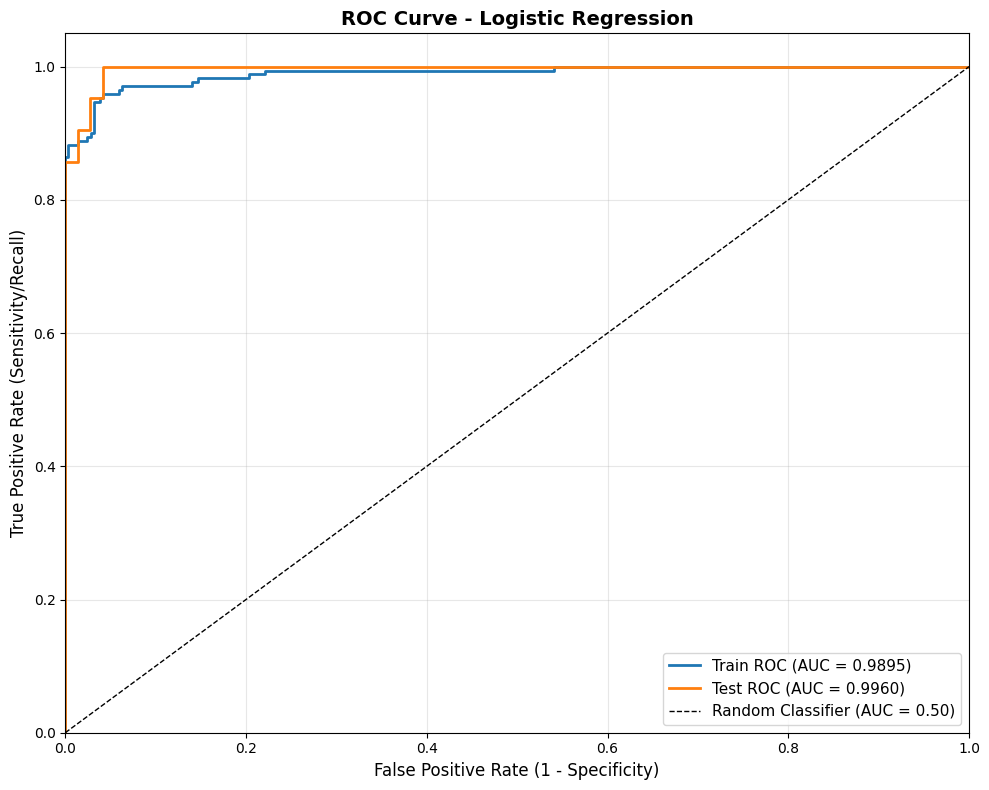

Train AUC: 0.9895
Test AUC: 0.9960


In [16]:
model = LRImpl()
model.fit(X_train_scaled, y_train)

print("Model trained successfully!")
print(f"Model coefficients shape: {model.coef_.shape}")
print(f"model coef: {model.coef_}")
print(f"Model intercept: {model.intercept_}")

# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy * 100:.2f}%)")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy * 100:.2f}%)")
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=["Benign", "Malignant"]))

# Get prediction probabilities for ROC and PR curves
y_train_proba = model.predict_proba(X_train_scaled)[:, 1]  # Probability of positive class
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

print("Prediction probabilities obtained")
print(f"Test probabilities range: [{y_test_proba.min():.4f}, {y_test_proba.max():.4f}]")

# Calculate ROC curve metrics
fpr_train, tpr_train, thresholds_roc_train = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, thresholds_roc_test = roc_curve(y_test, y_test_proba)

# Calculate AUC scores
auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.4f})", linewidth=2)
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {auc_test:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier (AUC = 0.50)", linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (1 - Specificity)", fontsize=12)
plt.ylabel("True Positive Rate (Sensitivity/Recall)", fontsize=12)
plt.title("ROC Curve - Logistic Regression", fontsize=14, fontweight="bold")
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Train AUC: {auc_train:.4f}")
print(f"Test AUC: {auc_test:.4f}")

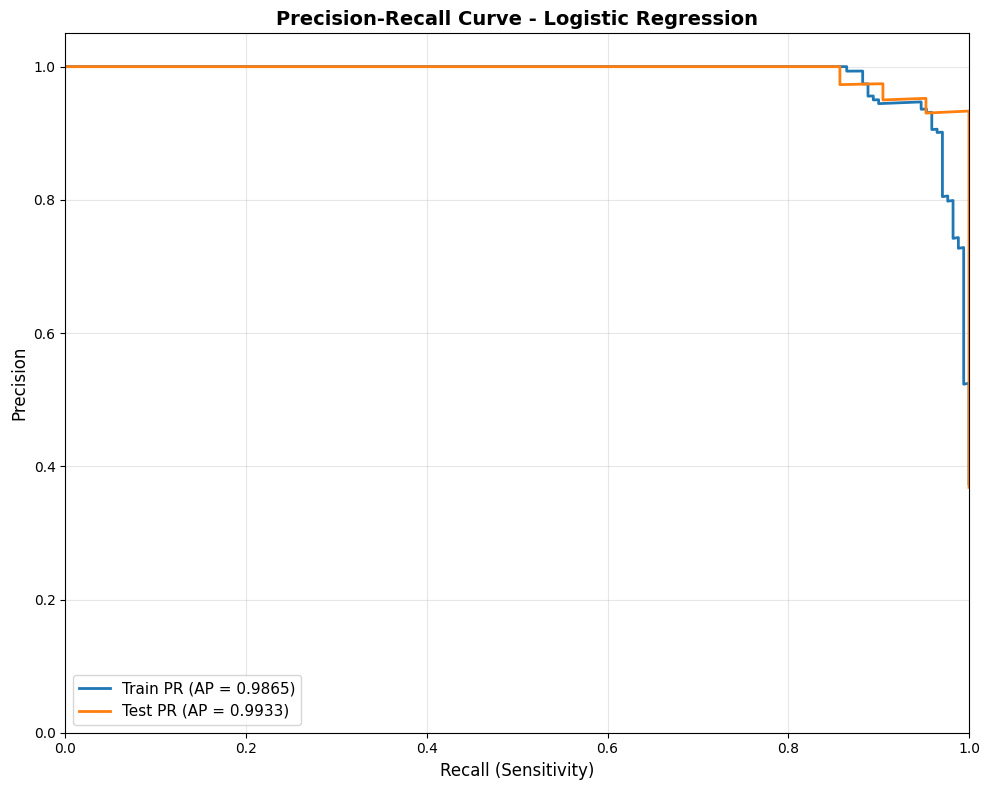

Train Average Precision: 0.9865
Test Average Precision: 0.9933


In [17]:
# Calculate Precision-Recall curve metrics
precision_train, recall_train, thresholds_pr_train = precision_recall_curve(y_train, y_train_proba)
precision_test, recall_test, thresholds_pr_test = precision_recall_curve(y_test, y_test_proba)

# Calculate Average Precision (AP) scores
ap_train = average_precision_score(y_train, y_train_proba)
ap_test = average_precision_score(y_test, y_test_proba)

# Plot PR curve
plt.figure(figsize=(10, 8))
plt.plot(recall_train, precision_train, label=f"Train PR (AP = {ap_train:.4f})", linewidth=2)
plt.plot(recall_test, precision_test, label=f"Test PR (AP = {ap_test:.4f})", linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall (Sensitivity)", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve - Logistic Regression", fontsize=14, fontweight="bold")
plt.legend(loc="lower left", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Train Average Precision: {ap_train:.4f}")
print(f"Test Average Precision: {ap_test:.4f}")